In [21]:
def comp_Zh(lx,dx):
    import math
    zh={}
    for x in lx:    
        x=math.floor(x/dx+0.5)*dx
        zh[x]=zh.get(x,0)+1
    for x in zh:zh[x]=float(zh[x])/dx
    lx=list(zh.keys())
    lx.sort()
    ly=[zh[x] for x in lx]
    return lx,ly

def comp_Zca(lx, a, dt=1, strict=False, dx=1e-3, zcmin=1e-8, mindx=1e-3):
    import math
    dzc={}
    tmax=len(lx)
    for i in range(0,tmax-dt):
        x=lx[i+dt]
        lastx=lx[i]
        d=abs(x-lastx)
        if a<0 and d<mindx:d=mindx
        if a==0: d=1 
        else: d=float(d)**a
        if dx!=None and not strict: 
            x=math.floor(x/dx)*dx
            lastx=math.floor(lastx/dx)*dx
        if lastx<x:
            dzc[lastx]=dzc.get(lastx,0)+d
            dzc[x]=dzc.get(x,0)-d
        else:  
            dzc[x]=dzc.get(x,0)+d
            dzc[lastx]=dzc.get(lastx,0)-d
    keys=list(dzc.keys())
    keys.sort()
    lx=[]
    ly=[]
    z=0
    for x in keys:
        lx.append(x)
        ly.append(float(z)/dt/2)
        z=z+dzc[x]
        if strict:
            lx.append(x)
            y=float(z)/dt/2
            if y<zcmin: y=0.0
            ly.append(y)
    if not strict:
        ly[0]=ly[1] # ly[0] equals 0, but a non-zero value is more convenieint for further analysis
    return lx,ly

def to_committor(traj,dx,x0,x1):
    import math
    lx,lzc1=comp_Zca(traj,a=1,dx=dx)
    x2q={}
    q=0
    for x,zc1 in zip(lx,lzc1):
        if x<=x0 or x>=x1:continue
        x2q[x]=q,1./zc1
        q+=1./zc1
    qm=q
    lq=[]
    for x in traj:
        xi=math.floor(x/dx)*dx
        if xi<=x0:lq.append(0)
        elif xi>=x1:lq.append(1)
        else:
            q,dqdx=x2q[xi]
            lq.append((q+(x-xi)*dqdx)/qm)
    return lq

from math import sin,cos,pi,log,exp
import numpy as np
import math

In [22]:
f=open('redtraj-5-0.rmsd')
traj=[]
for l in f:
    l=l.split()
    traj.append(float(l[1]))
f.close()

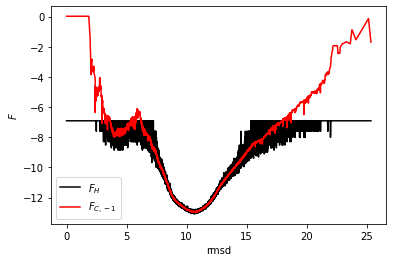

In [23]:
def f(x):
    if abs(x)<2:return sin(x*pi)*pi*0.5
    return -x*100

def D(x):
    return 1

dt=0.0005

dx=0.001
lx,lzh=comp_Zh(traj,dx=dx)
lf=[-log(z) for z in lzh if z>0]

lx2,lzh2=comp_Zca(traj,a=-1,dx=dx)
lf2=[-log(z*2) for z in lzh2 if z>0]

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(lx,lf,'k-',label='$F_H$')
plt.plot(lx2,lf2,'r-',label='$F_{C,-1}$')
plt.legend()
plt.xlabel('rmsd')
_=plt.ylabel('$F$')

In [24]:
lq=to_committor(traj,0.0001,4,11)

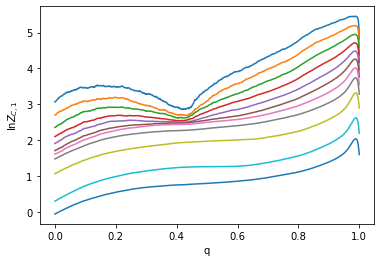

In [25]:
ldt=[2**i for i in range(11)]
dx=0.001
for dt in ldt:
    lx,lzc1=comp_Zca(lq,a=1,dx=dx,dt=dt)
    plt.plot(lx,np.log(lzc1))
plt.xlabel('q')
_=plt.ylabel('$\ln Z_{C,1}$')

In [26]:
# specifying the drift
def f(x):
    return -x

# specifying the diffusion coefficient
def D(x):
    return (1+math.cos(x))/2

dt=0.01

import matplotlib.pyplot as plt

<ipython-input-27-cb414762d49b>:4: RuntimeWarning: divide by zero encountered in log
  _=plt.plot(lx,np.log(ly))


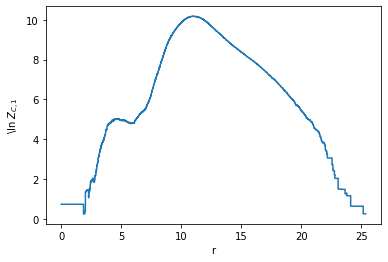

In [27]:
lx,ly=comp_Zca(traj,a=1,strict=True)
plt.xlabel('r')
plt.ylabel('\ln $Z_{C,1}$')
_=plt.plot(lx,np.log(ly))

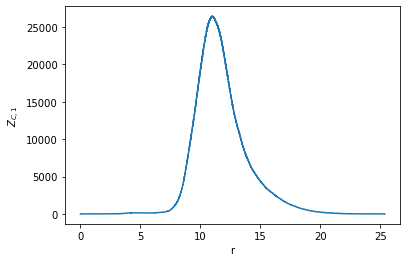

In [28]:
lx,ly=comp_Zca(traj,a=1,strict=True)
plt.xlabel('r')
plt.ylabel('$Z_{C,1}$')
_=plt.plot(lx,ly)

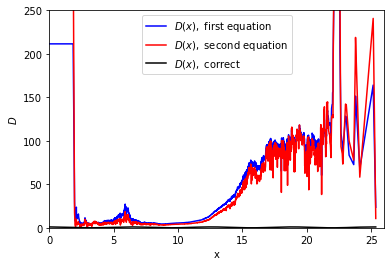

In [29]:
# compute Z_C,1, Z_C,-1 and Z_C
lx1,lzc1=comp_Zca(traj,a=1,dx=0.01)
lx2,lzcn1=comp_Zca(traj,a=-1,dx=0.01)
lx3,lzc=comp_Zca(traj,a=0,dx=0.01)

# compute diffusion coefficient using 1 and 2 equations
ld1=[zc1/zcn1/2/dt for zc1,zcn1 in zip(lzc1,lzcn1)]
ld2=[(zc/zcn1/2)**2/dt*math.pi for zc,zcn1 in zip(lzc,lzcn1)]

# make plot
plt.xlabel('x')
plt.ylabel('$D$')
plt.plot(lx1,ld1,'b',label='$D(x),$ first equation')
plt.plot(lx1,ld2,'r',label='$D(x),$ second equation')
plt.plot(lx1,[D(x) for x in lx1],'k',label='$D(x),$ correct')
plt.legend()
plt.xlim(0,26)
_=plt.ylim(0,250)

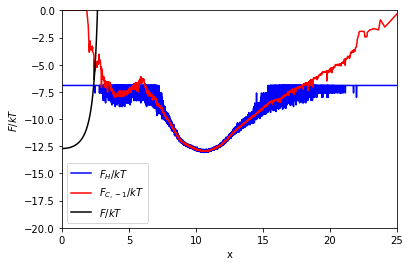

In [30]:
dx=0.001
# compute and plot F from Z_H
lx4,ly4=comp_Zh(traj,dx=dx)
lf4=[-math.log(y) for y in ly4]
plt.plot(lx4,lf4,'b-',label='$F_H/kT$')

# compute and plot F from Z_C,-1
lx5,ly5=comp_Zca(traj,a=-1,dx=dx)
lf5=[-math.log(2*y) for y in ly5]
plt.plot(lx5,lf5,'r-',label='$F_{C,-1}/kT$')


# compute and plot analytical free energy profile
lx=[i*0.01 for i in range(-300,301)]
lD=[D(x) for x in lx]
lfD=[-f(x)/D(x) for x in lx]
    
from scipy.integrate import cumtrapz
lI=cumtrapz(lfD,lx,initial=0)
lF=[I+math.log(D) for I,D in zip(lI,lD)]

# shift F, so that plots conside
du=lF[300]-lf5[int(len(lf5)/2)]
lF=[u-du for u in lF]

plt.plot(lx, lF,'k-',label='$F/kT$')

plt.legend()
plt.xlabel('x')
plt.ylim((-20,0))
plt.xlim((0,25))
_=plt.ylabel('$F/kT$')

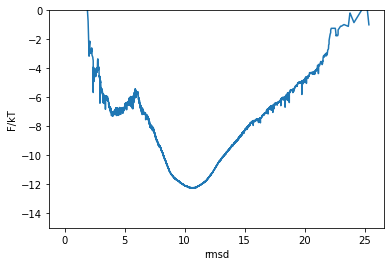

In [31]:
def f(x):
    if abs(x)<2:return sin(x*pi)*pi*0.5
    return -x*100
def D(x):
    return 1

# run diffusion and compute the profile
dt=0.001
lx,ly=comp_Zca(traj,a=-1,dx=0.001)
ly=[-log(y) for y in ly]

# plot the profile
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(lx,ly)
plt.ylim(-15,0)
plt.ylabel('F/kT')
_=plt.xlabel('rmsd')

In [32]:
def Nab_traj(traj,a,b):
    il=None
    n=0
    for x in traj:
        ic=None
        if x<a: ic=1
        if x>b: ic=2
        if ic!=None and il!=None and ic!=il: n+=1
        if ic!=None: il=ic
    return n/2.
        
def Nab_model(lx,lzc1,a,b):
    lx1=[lx[i] for i in range(len(lx)) if a<lx[i] and lx[i]<b]
    ly1=[1/lzc1[i] for i in range(len(lx)) if a<lx[i] and lx[i]<b]
    
    from scipy.integrate import simps
    I=simps(ly1,lx1)
    return 1./I

a=4
b=11
lx1,ly1=comp_Zca(traj,a=1,dx=0.0001)
print (Nab_traj(traj,a,b),Nab_model(lx1,ly1,a,b))

11.0 43.64312083084235


In [33]:
for dt in range(1,10):
    traj1=[traj[i] for i in range(1,len(traj),dt)]
    lx1,ly1=comp_Zca(traj1,a=1,dx=0.0001)
    print (dt,Nab_traj(traj1,a,b),Nab_model(lx1,ly1,a,b))

1 11.0 43.64312083084235
2 10.0 33.406126562289714
3 10.0 30.819010936007466
4 8.0 28.393434081388556
5 9.0 27.243084258414985
6 9.0 26.525111106802974
7 9.0 23.89020230816528
8 7.0 23.974667092220322
9 10.0 24.760510521252797


In [15]:
# cumtrapz removed ly=[1/y for y in lzc1] lq=cumtrapz(ly,lx,initial=0)lqa=[(abs(x-a),i) for i,x in enumerate(lx)]
def fab_model(traj,a,b,dx=0.001):
    lx,lzc1=comp_Zca(traj,1,dx=dx)
    lx,lzh=comp_Zca(traj,-1,dx=dx)
    from scipy.integrate import cumtrapz,simps
    ly=[1/y for y in lzc1]
    lq=cumtrapz(ly,lx,initial=0)
    lqa=[(abs(x-a),i) for i,x in enumerate(lx)]
    lqa.sort()
    ia=lqa[0][-1]
    qa=lq[ia]
    lqb=[(abs(x-b),i) for i,x in enumerate(lx)]
    lqb.sort()
    ib=lqb[0][-1]
    qb=lq[ib]
    def qp(q,qa,qb):
        if q<qa: return 0
        if q>qb: return 1
        return (q-qa)/(qb-qa)
    lqp=[qp(q,qa,qb) for q in lq]
    lind=[1 if a<x and x<b else 0 for x in lx]
    nab=1/simps([ind/zc1 for ind,zc1 in zip(lind,lzc1)],lx)
    n=len(traj)
    ztot=simps(lzh,lx)
    mfptab=simps([zh*(1-q) for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    mfptba=simps([zh*q for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    mtpt=simps([zh*q*(1-q) for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    return nab,mfptab,mfptba,mtpt

def fab_traj(traj,a,b):
    il=None
    nab=0
    mfptab=0
    mfptba=0
    mtpt=0
    tp=0
    fp=0
    for i,x in enumerate(traj):
        if x<a: 
            ic=1
            if il!=None and ic!=il:
                nab=nab+1
                mtpt=mtpt+i-tp
                mfptba=mfptba+i-fp
                fp=i
            il=ic
            tp=i
        if x>b: 
            ic=2
            if il!=None and ic!=il:
                nab=nab+1
                mtpt=mtpt+i-tp
                mfptab=mfptab+i-fp
                fp=i
            il=ic
            tp=i
    return nab/2.,2.*mfptab/nab,2.*mfptba/nab,float(mtpt)/nab
    
a=4
b=11  
print('model: NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_model(traj,a,b))    
print('traj:  NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_traj(traj,a,b))

model: NAB=43.6309, mfpt_AB=12405.9, mftp_BA=16453.7, mtpt=159.506
traj:  NAB=11, mfpt_AB=526.364, mftp_BA=109830, mtpt=153.909
